### Load dataset

In [1]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
wandb.init(project="binary_search_optimization", name="verysmall_unbalance")

W&B Run: https://app.wandb.ai/panuthep/binary_search_optimization/runs/thyve35h

In [3]:
DATASET_DIRS = "./Datasets/dataset_verysmall.pkl"
MAX_MONSTER_NUM = 1000
MONSTER_HP_COLUMNS = ["monster_hp_" + str(num) for num in range(1, MAX_MONSTER_NUM + 1)]
FEATURES = ["focus_damage", "aoe_damage", *MONSTER_HP_COLUMNS]
TARGET = ["attack_num"]

In [4]:
dataset = pd.read_pickle(DATASET_DIRS)

In [5]:
for col in ["focus_damage", "aoe_damage", "attack_num"]:
    plt.hist(dataset[col])
    wandb.log({col: plt})

Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds
/anaconda3/envs/dev/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



### Train test split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_set, test_set = train_test_split(dataset, random_state=42, shuffle=True)

In [ ]:
bins = np.linspace(dataset[TARGET].to_numpy().min(), dataset[TARGET].to_numpy().max(), 100, dtype=int)
Y_bin = np.digitize(dataset[TARGET].to_numpy(), bins)

train_set, test_set = train_test_split(dataset, random_state=42, shuffle=True, stratify=Y_bin)

In [8]:
X_train, Y_train = train_set[FEATURES].to_numpy(), train_set[TARGET].to_numpy()
X_test, Y_test = test_set[FEATURES].to_numpy(), test_set[TARGET].to_numpy()

In [9]:
len(X_train), len(X_test)

(68250, 22750)

### Normalization

In [10]:
import joblib
from sklearn.preprocessing import MinMaxScaler

In [11]:
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = X_scaler.transform(X_test.astype(np.float32))

Y_scaler = MinMaxScaler()
Y_train_scaled = Y_scaler.fit_transform(Y_train.astype(np.float32))
Y_test_scaled = Y_scaler.transform(Y_test.astype(np.float32))

In [ ]:
joblib.dump(Y_scaler, "./Save/Y_scaler.pkl")
joblib.dump(X_scaler, "./Save/X_scaler.pkl")

### Model

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MAE
from utilities import LearningRateFinder

In [13]:
wandb.config.network_depth = 1
wandb.config.network_width = 16
wandb.config.activation = "LeakyReLU"
wandb.config.optimizer = "Adam"
wandb.config.loss = "MAE"
wandb.config.epochs = 100
wandb.config.batch_size = 32
wandb.config.validation_split = 0.2

Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


In [14]:
def history_plot(history):
    x = list(range(len(history.history["loss"])))
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    plt.subplot(2, 1, 1)
    plt.title("loss")
    plt.plot(x, loss)
    plt.subplot(2, 1, 2)
    plt.title("val_loss")
    plt.plot(x, val_loss)
    
def losses_plot(Y_true, Y_pred):
    losses = MAE(Y_true, Y_pred)
    plt.scatter(Y_pred, losses)
    plt.show()
    
def prediction_distribution(pred):
    plt.hist(pred, bins=100)
    plt.show()

In [15]:
input_shape = [X_train.shape[1]]

In [19]:
class SequenceDense(Model):
    def __init__(self):
        super().__init__()
        self.hidden_layers = []
        for _ in range(wandb.config.network_depth):
            self.hidden_layers.append(Dense(wandb.config.network_width, activation=LeakyReLU()))
        self.output_layer = Dense(1, activation="relu")
        
    def call(self, inputs):
        output = inputs
        for layer in self.hidden_layers:
            output = layer(output)
        output = self.output_layer(output)
        
        return output

In [27]:
model_name = "model_{}_{}".format(wandb.config.network_depth, wandb.config.network_width)

# Save or load initial model, so every time, we start with the same init model
model = SequenceDense()
model.compile(optimizer=Adam(learning_rate=0.0001), loss="mae")
# model.save_weights("./Save/Model_initial/" + model_name)
model.load_weights("./Save/Model_initial/" + model_name)

Train on 68250 samples
Epoch 1/20
68250/68250 [==============================] - 3s 46us/sample - loss: 0.0969
Epoch 2/20
68250/68250 [==============================] - 2s 36us/sample - loss: 0.0969
Epoch 3/20
68250/68250 [==============================] - 2s 35us/sample - loss: 0.0964
Epoch 4/20
68250/68250 [==============================] - 2s 35us/sample - loss: 0.0940
Epoch 5/20
68250/68250 [==============================] - 2s 35us/sample - loss: 0.0876
Epoch 6/20
68250/68250 [==============================] - 2s 35us/sample - loss: 0.0775
Epoch 7/20
68250/68250 [==============================] - 2s 34us/sample - loss: 0.0704
Epoch 8/20
68250/68250 [==============================] - 2s 34us/sample - loss: 0.0675
Epoch 9/20
68250/68250 [==============================] - 2s 34us/sample - loss: 0.0607
Epoch 10/20
68250/68250 [==============================] - 2s 34us/sample - loss: 0.0494
Epoch 11/20
68250/68250 [==============================] - 2s 34us/sample - loss: 0.0454
Epoch 1

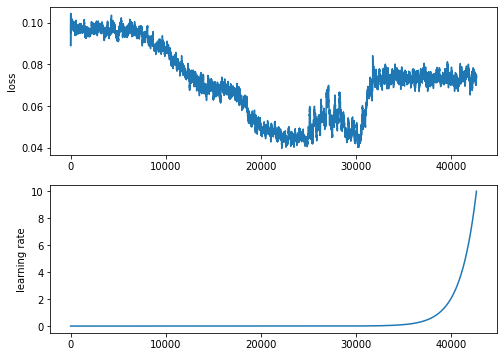

In [28]:
lr_finder = LearningRateFinder(model)
lr_finder.find((X_train_scaled, Y_train_scaled), start_lr=1e-10, epochs=20)
lr_finder.plot()

In [23]:
plt.plot(lr_finder.losses)
wandb.log({"lr_finder": plt})

Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds
/anaconda3/envs/dev/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



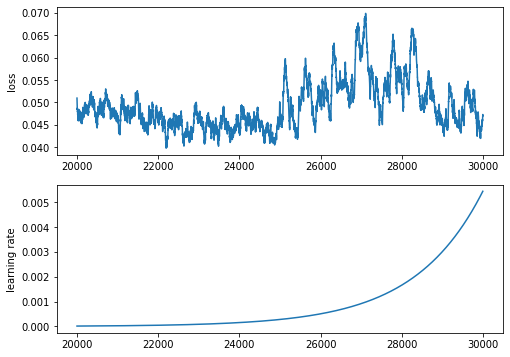

In [38]:
lr_finder.plot(start=20000, end=30000)

In [ ]:
lr_finder.lrs[200000]

Train on 54600 samples, validate on 13650 samples
Epoch 1/100
54600/54600 [==============================] - 2s 42us/sample - loss: 0.0739 - val_loss: 0.0729
Epoch 2/100
54600/54600 [==============================] - 2s 34us/sample - loss: 0.0734 - val_loss: 0.0719
Epoch 3/100
54600/54600 [==============================] - 2s 36us/sample - loss: 0.0586 - val_loss: 0.0545
Epoch 4/100
54600/54600 [==============================] - 2s 33us/sample - loss: 0.0427 - val_loss: 0.0391
Epoch 5/100
54600/54600 [==============================] - 2s 33us/sample - loss: 0.0404 - val_loss: 0.0376
Epoch 6/100
54600/54600 [==============================] - 2s 33us/sample - loss: 0.0393 - val_loss: 0.0387
Epoch 7/100
54600/54600 [==============================] - 2s 33us/sample - loss: 0.0383 - val_loss: 0.0358
Epoch 8/100
54600/54600 [==============================] - 2s 33us/sample - loss: 0.0374 - val_loss: 0.0356
Epoch 9/100
54600/54600 [==============================] - 2s 32us/sample - loss: 0.03

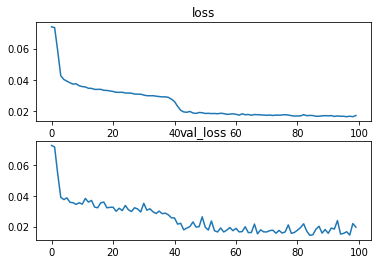

In [45]:
model = SequenceDense()
model.load_weights("./Save/Model_initial/" + model_name)

model.compile(optimizer=Adam(learning_rate=lr_finder.lrs[24000]), loss="mae")
history = model.fit(X_train_scaled, Y_train_scaled, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

history_plot(history)

In [44]:
x = list(range(len(history.history["loss"])))
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.subplot(2, 1, 1)
plt.title("loss")
plt.plot(x, loss)
plt.subplot(2, 1, 2)
plt.title("val_loss")
plt.plot(x, val_loss)
wandb.log({"model": plt})

Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds
/anaconda3/envs/dev/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



In [46]:
model.evaluate(X_test_scaled, Y_test_scaled, verbose=2)

22750/1 - 0s - loss: 0.0167


0.019715340683093437

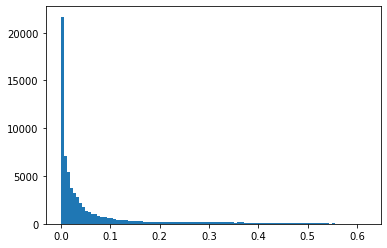

In [47]:
# Inbalance dataset is highly possible due to the following prediction distriburion.
pred = model.predict(X_train_scaled)
prediction_distribution(pred)

In [ ]:
model.save_weights("./Save/Model_without_decay/model_1024")

In [ ]:
model = SequenceDense()
model.load_weights("./Save/Model_without_decay/model_1024")

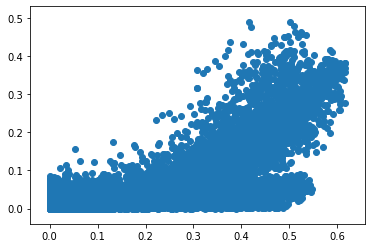

In [48]:
losses_plot(Y_train_scaled, pred)